## Zero Padding of ZOGY Decorrelation Kernel

Author: Shu Liu

This notebook is inspired by the work of `https://github.com/lsst-dm/diffimTests/blob/master/tickets/DM-21920_fft_padding_freq_shift/fft_space_paddings_high_freq_shift.ipynb`

###  Abstract

This notebook explores the shape of ZOGY [1] `decorrelation` kernel with different padding sizes of point spread functions (PSF). Padding PSFs with different numbers of zeros before kernel calculation results in different `decorrelation` kernels in image space. This is related to the relationship between zero padding in image space and interpolation in Fourier space. Whether these kernels would converge to a limit by increasing the padding size is still an open question. We demonstrate these topics both graphically and mathematically. The mathematical derivation is mainly from [2].

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift
import matplotlib.pyplot as plt

In [2]:
# These functions are inspired by the code from [3]

def pad_zeros(data, pad_num=0):
    # Pad a 1d array with pad_num zeros on both sides.
    # E.g. an input of data=np.array([1,2,3,3,2,1]) and pad_num=3 would output array([0,0,0,1,2,3,3,2,1,0,0,0]).
    if pad_num == 0:
        return data
    data_len = data.shape[0]
    new_data = np.zeros(data_len + 2 * pad_num)
    new_data[pad_num:-pad_num] = data
    return new_data
    
def gaussian(x, m=0., s=1.0, pad_num=0):
    # Create a 1d Gaussian with mean=m, std=s at position x.
    # The Gaussian would be padded by pad_num zeros on both sides.
    gau = 1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)**2./(2.*s**2.))
    if pad_num > 0:
        gau = pad_zeros(gau, pad_num)
    return gau / gau.sum() / (x[1] - x[0])

def gaussian_ft(x, m=0., s=1.0, pad_num=0):
    # Take the Fourier transfrom of a Gaussian array from the output of the gaussian() function.
    gau = gaussian(x, m, s, pad_num=pad_num)
    gau_ft = fft(gau)
    gau_ft *= (x[1]-x[0])
    return gau_ft

# Technique note: The complex phase of the PSF returnd by gaussian_ft() are actually shifted because the
# PSF from gaussian() is not shifted to the [0, 0] position (Translation in image space 
# corresponds to phase shift in Fourier space). However, this would not affect our result because we only
# need the absolute value at each frequency for calculating the decorrelation kernel.
    
def decorr_kernel_ft(x, sign=1., sigr=1., m=0., psfsign=1.5, psfsigr=1., pad_num=0):
    # Calculate the decorrelation kernel of the ZOGY difference image in Fourier space. Both PSFs are
    # padded by pad_num zeors to both sides in image space before the Fourier transformation.
    # sig: skybackground error, psfsig: sigma of the PSF.
    
    psfn_ft = gaussian_ft(x, m, psfsign, pad_num=pad_num)
    psfr_ft = gaussian_ft(x, m, psfsigr, pad_num=pad_num)
    
    return 1 / np.sqrt(
        sign**2 * np.abs(psfr_ft)**2 + sigr**2 * np.abs(psfn_ft)**2
    )

def decorr_kernel(x, sign=1., sigr=1., m=0., psfsign=1.5, psfsigr=1., pad_num=0):
    # Calculate the ZOGY decorrelation kernel.
    decorr_ft = decorr_kernel_ft(x, sign=1., sigr=1., m=0., psfsign=1.5, psfsigr=1., pad_num=pad_num)
    decorr = ifft(decorr_ft)
    # Translate the center of the kernel to the center of the array.  
    decorr = ifftshift(decorr.real)
    return decorr

### 1. Introduction

The ZOGY([1]) differrence imaging algorithm suggests a difference image with the form:

$$
\widehat{D} = \frac{F_r\widehat{P_r}\widehat{N} - F_n\widehat{P_n}\widehat{R}}{\sqrt{\sigma_n^2 F_r^2 |\widehat{P_r}|^2 + \sigma_r^2 F_n^2 |\widehat{P_n}|^2}}. \quad (1)
$$

In addition to cross matching each other's PSF of two images, ZOGY algorithm introduces a `decorrelation` kernel which normalizes the variance at each frequency. This `decorrelation` kernel is given by:

$$
\widehat{ker} = \frac{1}{\sqrt{\sigma_n^2 F_r^2 |\widehat{P_r}|^2 + \sigma_r^2 F_n^2 |\widehat{P_n}|^2}}. \quad(2)
$$

For calculating and applying this kernel, two methods are possible. The first method is to pad both PSFs to the image size, then transform them to the Fourier space. In the Fourier space, the kernel would be calculated and applied. The second method is to transform both PSFs to the Fourier space without any zero padding. We calculate the kernel using (2), and transform it back to the image space. This would give us a kernel with much smaller size compared to images. The decorrelation is eventually applied in the image space by convolution process.

The first method is proper since it is applied as the algorithm requires. The second method, however, seems proper at first glance but actually has hidden troubles. In this notebook, we start with implementations of the `decorrelation` kernel with different zero padding sizes. By plotting these kernels, we can visually confirm that zero padding does change the shape of the kernel. Then we give a derivation for these methods using the relationship between discrete time Fourier transform (DTFT) and discrete Fourier transform (DFT), which proves that they are actually mathematically different. In fact, zero padding in image space is just interpolation in Fourier space.

### 2. Plotting Decorrelation Kernel

#### 2.1 PSF Size: 100 pixels.

In [3]:
# Define the grid for generating PSFs.
x = np.arange(-5,5,0.1)
print(f'The length of the PSF is {len(x)} pixels')

# Padding sizes at both sides of the PSF.
pad_list = [0, 100, 300, 600, 1000]

The length of the PSF is 100 pixels


Here we calculate decorrelation kernels with different padding sizes. For example, pad_zeros=100 means we pad PSFs with 100 zeros at both sides. Then we transform them to Fourier space, calculate the kernel and then transform it back to image space. In image space, we pad zeros to both sides of the decorrelaiton kernel to make sure we can plot different kernels with the same pixel range. 

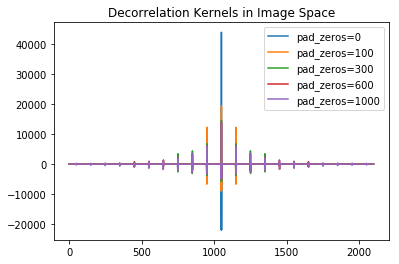

In [202]:
max_pad = pad_list[-1]
for i in pad_list:
    ker = decorr_kernel(x, pad_num=i)
    ker_pad = pad_zeros(ker, pad_num=max_pad-i)
    plt.plot(ker_pad, label=f'pad_zeros={i}')
plt.title('Decorrelation Kernels in Image Space')
plt.legend()


Obviously, these kernels are visually different. They could peak at the same position but with different magnitudes. Also, kernels with large padding sizes can have smaller peaks near the two edges of the image. But kernels with small padding sizes can not reach that far. Next, we zoom into the center of these kernels.

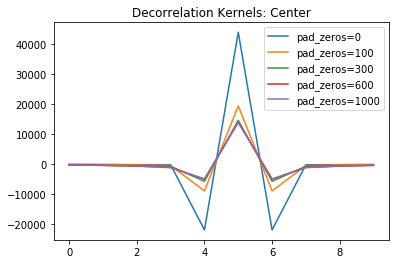

In [203]:
max_pad = pad_list[-1]
for i in pad_list:
    ker = decorr_kernel(x, pad_num=i)
    ker_pad = pad_zeros(ker, pad_num=max_pad-i)[1045:1055]
    plt.plot(ker_pad, label=f'pad_zeros={i}')
plt.title('Decorrelation Kernels: Center')
plt.legend()


By zooming into the center of these kernels, we find that there are offsets between them. It seems that kernels with smaller padding sizes oscillate more dramatically. Next, we check the edge of these kernels.

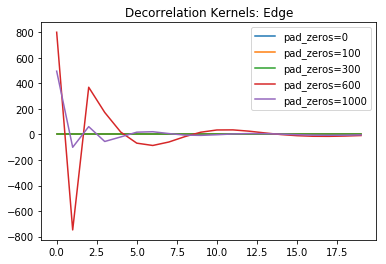

In [204]:
max_pad = pad_list[-1]
for i in pad_list:
    ker = decorr_kernel(x, pad_num=i)
    ker_pad = pad_zeros(ker, pad_num=max_pad-i)[450:470]
    plt.plot(ker_pad, label=f'pad_zeros={i}')
plt.title('Decorrelation Kernels: Edge')
plt.legend()

Here we find that there is a big offset between pad_zeros=600 and pad_zeros=1000. The kernel with smaller padding sizes (pad_zeros=600) oscillates more dramatically. Next, we check the region between the edge and the center.

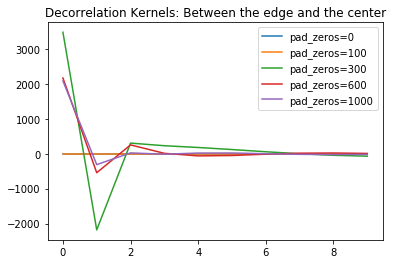

In [205]:
max_pad = pad_list[-1]
for i in pad_list:
    ker = decorr_kernel(x, pad_num=i)
    ker_pad = pad_zeros(ker, pad_num=max_pad-i)[750:760]
    plt.plot(ker_pad, label=f'pad_zeros={i}')
plt.title('Decorrelation Kernels: Between the edge and the center')
plt.legend()

In the region between the edge and the center, there are also offsets. Again, kernels with smaller padding sizes oscillate more dramatically.

In the plots above, we compare decorrelation kernels with PSFs of 100 pixels. It seems that when increasing the padding sizes, the kernel is converging to a limit function. Let us decrease the PSF to 50 pixels (smaller sampling frequency) and see what happens.

#### 2.2 PSF Size: 50 pixels (lower sampling rate).

In [206]:
x = np.arange(-5,5,0.2)
print(f'The length of the PSF is {len(x)} pixels')

The length of the PSF is 50 pixels


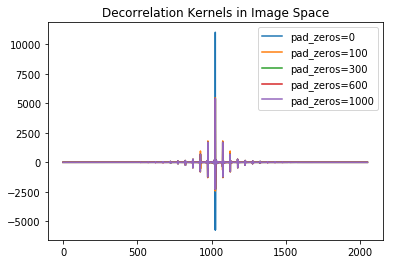

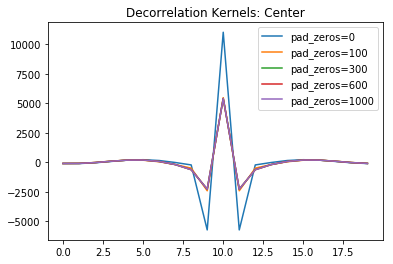

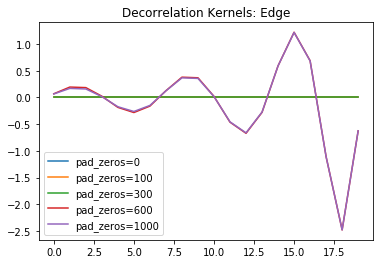

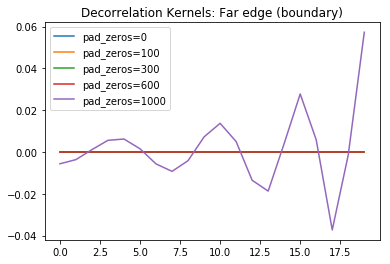

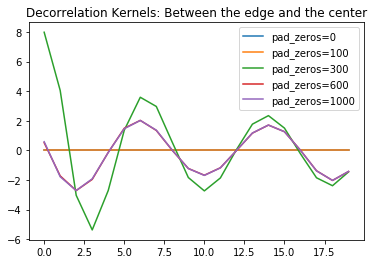

In [211]:
plt.figure()
max_pad = pad_list[-1]
for i in pad_list:
    ker = decorr_kernel(x, pad_num=i)
    ker_pad = pad_zeros(ker, pad_num=max_pad-i)
    plt.plot(ker_pad, label=f'pad_zeros={i}')
plt.title('Decorrelation Kernels in Image Space')
plt.legend()

plt.figure()
max_pad = pad_list[-1]
for i in pad_list:
    ker = decorr_kernel(x, pad_num=i)
    ker_pad = pad_zeros(ker, pad_num=max_pad-i)[1015:1035]
    plt.plot(ker_pad, label=f'pad_zeros={i}')
plt.title('Decorrelation Kernels: Center')
plt.legend()

plt.figure()
max_pad = pad_list[-1]
for i in pad_list:
    ker = decorr_kernel(x, pad_num=i)
    ker_pad = pad_zeros(ker, pad_num=max_pad-i)[500:520]
    plt.plot(ker_pad, label=f'pad_zeros={i}')
plt.title('Decorrelation Kernels: Edge')
plt.legend()

plt.figure()
max_pad = pad_list[-1]
for i in pad_list:
    ker = decorr_kernel(x, pad_num=i)
    ker_pad = pad_zeros(ker, pad_num=max_pad-i)[0:20]
    plt.plot(ker_pad, label=f'pad_zeros={i}')
plt.title('Decorrelation Kernels: Far edge (boundary)')
plt.legend()

plt.figure()
max_pad = pad_list[-1]
for i in pad_list:
    ker = decorr_kernel(x, pad_num=i)
    ker_pad = pad_zeros(ker, pad_num=max_pad-i)[780:800]
    plt.plot(ker_pad, label=f'pad_zeros={i}')
plt.title('Decorrelation Kernels: Between the edge and the center')
plt.legend()



So we find that by decreasing the PSF size (sampling frequency), the decorrelation kernel converges more quickly. It is hard to tell the difference between pad_zeros=600 and pad_zeros=1000. However, a kernel with 1200 pixels (pad_zeros=600) is still too large for computation as a convolution process.

### 3. Mathematical Derivation

Here we present the mathematical expression of the two methods discussed above:

- Method 1: Pad PSFs to image size before kernel calculation.
- Method 2: Calculate the decorrelation kernel without padding PSFs.

The derivation below is mainly from [2], however, we use a different convention for calculating the Fourier transform.

For an infinite series $x[n]$, $n \in \mathbb{N}$, the discrete time Fourier transform(DTFT) maps it to a continuous fucntion $\tilde X[\omega]$ with period equals 2$\pi$ by:

\begin{align}
\tilde X[\omega] = \sum_{n=-\infty}^{\infty}x[n]e^{-jn\omega}. \quad(3)
\end{align}

If the series $x[n]$ is zero outside of $[-\frac{N}{2} , \frac{N}{2}-1]$, the DTFT would be truncated to:

\begin{align}
\tilde X[\omega] = \sum_{n=-\frac{N}{2}}^{\frac{N}{2}-1}x[n]e^{-jn\omega},\quad \textit{N is even}.\quad(4)
\end{align}

Next, we introduce the discrete Fourier transform, which is defined as:

\begin{align}
X[k] & = \frac{1}{N}\sum_{n=0}^{N-1}x[n]e^{-j2\pi nk/N}, \quad \textit{k = 0, 1, 2..., N-1} \\
     & = \frac{1}{N}\sum_{n=-\frac{N}{2}}^{\frac{N}{2}-1}x[n]e^{-j2\pi nk/N}, \quad \textit{k = -N/2, 1, 2..., N/2 - 1} \quad(5)
\end{align}

Here we assume the periodical boundary condition for $x[n]$. By comparing (4) and (5), we recognize that:

\begin{align}
X[k] = \frac{1}{N}\tilde X[2\pi k/N], \quad \textit{k = -N/2, 1, 2..., N/2 - 1}. \quad(6)
\end{align}

So the DFT is simply the sampling version of the truncated DTFT except an overall factor $1/N$.

Now we express $\tilde X[\omega]$ in terms of $X[k]$, note that the inverse Fourier transform is given by:

\begin{align}
x[n] &= \sum_{k=0}^{k=N-1}X[k]e^{j2\pi nk/N}, \quad \textit{n = 0, 1, 2..., N-1} \\
     & = \sum_{k=-\frac{N}{2}}^{k=\frac{N}{2}-1}X[k]e^{j2\pi nk/N}, \quad \textit{n = -N/2, 1, 2..., N/2 - 1} \quad(7)
\end{align}

So we have:

\begin{align}
\tilde X[\omega] & = \sum_{n=-\frac{N}{2}}^{\frac{N}{2}-1}x[n]e^{-jn\omega}\\
                 & = \sum_{n=-\frac{N}{2}}^{\frac{N}{2}-1}
                 \sum_{k=-\frac{N}{2}}^{\frac{N}{2}-1}X[k]e^{j2\pi nk/N} e^{-jn\omega} \\
                 & = \sum_{k=-\frac{N}{2}}^{\frac{N}{2}-1}X[k] 
                         \sum_{n=-\frac{N}{2}}^{\frac{N}{2}-1}
                             e^{-jn(\omega - 2\pi k/N)}. \quad(8)
\end{align}

Note that the last summation in (8) is a summation of geometric series, define:
\begin{align}
G_N(\lambda) & = \sum_{n=-\frac{N}{2}}^{\frac{N}{2}-1}e^{-jn\lambda} \\
           & = e^{j\lambda/2}\frac{sin(N\lambda/2)}{sin(\lambda/2)}. \quad(9)
\end{align}

So we have:

$$
\tilde X[\omega] = \sum_{k=-\frac{N}{2}}^{\frac{N}{2}-1}X[k] G_N(\omega - 2\pi k/N). \quad(10)
$$


Now suppose we pad $x[n]$ by $(L-N)/2$ zeros for both sides, then nominally we have a series with $L$ elements ($\textit{L is even}$). This does not affect the truncated $\tilde X[\omega]$ defined in (4) since the zero components have no contribution to $\tilde X[\omega]$. For the DFT, however, we have:

\begin{align}
X[l] &= \frac{1}{L}\sum_{n=-\frac{N}{2}}^{\frac{N}{2}-1}x[n]e^{-j2\pi nl/L}\\
     &= \frac{1}{L}\tilde X[2\pi l/L]
      \\
     &= \frac{1}{L}\sum_{k=-\frac{N}{2}}^{\frac{N}{2}-1}X[k] G_N(2\pi l/L - 2\pi k/N), \quad \textit{l = -L/2, 1, 2..., L/2 - 1} \quad(11)
\end{align}

From (11), we can conclude that zero padding the series $x[n]$ in image space to length $L$ is equivalent to interpolate $X[k]$ by $G_N((2\pi l/L - 2\pi k/N))$ in Fourier space.


Now we apply (11) to the two methods discussed above. The first method requires to pad both PSFs to the image size before calculating the `decorrelation` kernel. Suppose both PSFs has size N and the image size is L. Set $F_n=F_r=1$, By combining (2) and (11), we have:

$$
\widehat{ker[l]} = \frac{1}{\sqrt{\sigma_n^2 |\frac{1}{L}\sum_{k=-\frac{N}{2}}^{\frac{N}{2}-1}\widehat{P_r[k]} G_N(2\pi l/L - 2\pi k/N)|^2 + \sigma_r^2  |\frac{1}{L}\sum_{k=-\frac{N}{2}}^{\frac{N}{2}-1}\widehat{P_n[k]} G_N(2\pi l/L - 2\pi k/N)|^2}}. \quad (12)
$$

The second method, which simply calculates the `decorrelation` kernel without any padding, is given by the equation (2). However, we can pad the kernel from (2) to the image size, and transform it to the Fourier for comparison to (12), this gives us:

$$
\widehat{ker^{'}[l]}= \frac{1}{L}\sum_{k=-\frac{N}{2}}^{k=\frac{N}{2}-1}\frac{1}{\sqrt{\sigma_n^2 |\widehat{P_r[k]}|^2 + \sigma_r^2 |\widehat{P_n[k]}|^2}} G_N(2\pi l/L - 2\pi k/N). \quad (13)
$$

So we can see that these methods are mathematically different.

### 4. Conclusion.

From this notebook we demonstrate that simply keeping the original size of PSFs without zero padding cannot give the proper `decorrelation` kernel. Also, padding PSFs to different sizes produce different kernels. These kernels have similar shapes and usually peak near the same position. Kernels with smaller padding sizes oscillate more dramatically. It seems that these kernels will converge to a limit function by increasing the padding size. Decreasing the PSF size (decreasing sampling rate) would also help them converge more quickly. But whether it is true in general or does this convergence limit exist is still an open question. 

#### Reference
[1] Zackay, B., et al. https://arxiv.org/abs/1601.02655

[2] Zero Padding of FFT. https://dsp.stackexchange.com/questions/24410/zero-padding-of-fft/24426#24426

[3] 01. Understand Lupton(ZOGY) post convolution kernel - add preconvolution.ipynb. https://github.com/lsst-dm/diffimTests/blob/master/notebooks/01.%20Understand%20Lupton(ZOGY)%20post%20convolution%20kernel%20-%20add%20preconvolution.ipynb